In [1]:
import os, shutil
import random
import numpy as np
import pandas as pd
import cv2
import skimage
import matplotlib.pyplot as plt
import skimage.segmentation
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

In [2]:
labels = ['PNEUMONIA','NORMAL']
img_size = 224

def get_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(f"Error loading {img}: {e}")
    return data


In [3]:
train = get_data("/kaggle/input/chest-xray-pneumonia/chest_xray/train")
test = get_data("/kaggle/input/chest-xray-pneumonia/chest_xray/test")
val = get_data("/kaggle/input/chest-xray-pneumonia/chest_xray/val")
pneumonia = os.listdir("/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA")
penomina_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA"

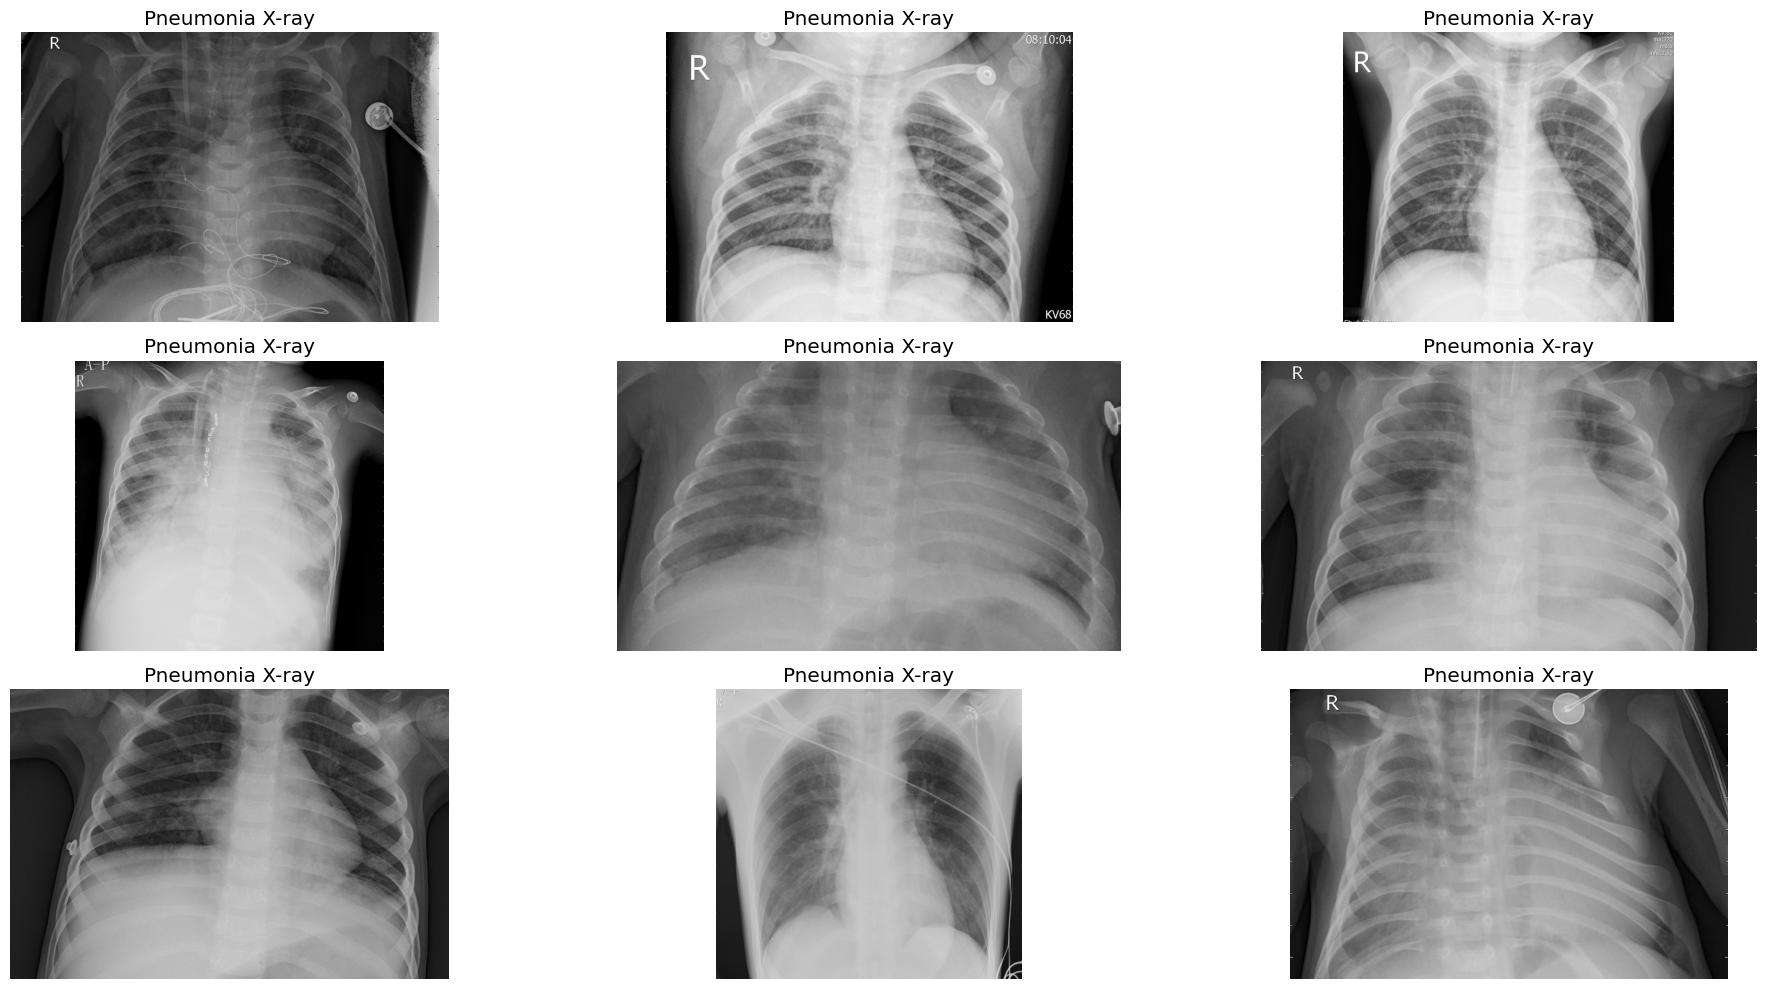

In [4]:
plt.figure(figsize=(20,10))

for i in range(9):
    plt.subplot(3,3, i+1)
    img = plt.imread(os.path.join(penomina_dir, pneumonia[i]))
    plt.imshow(img, cmap='gray')
    plt.axis("off")
    plt.title("Pneumonia X-ray")
plt.tight_layout()

In [5]:
normal = os.listdir("/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL")
normal_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL"

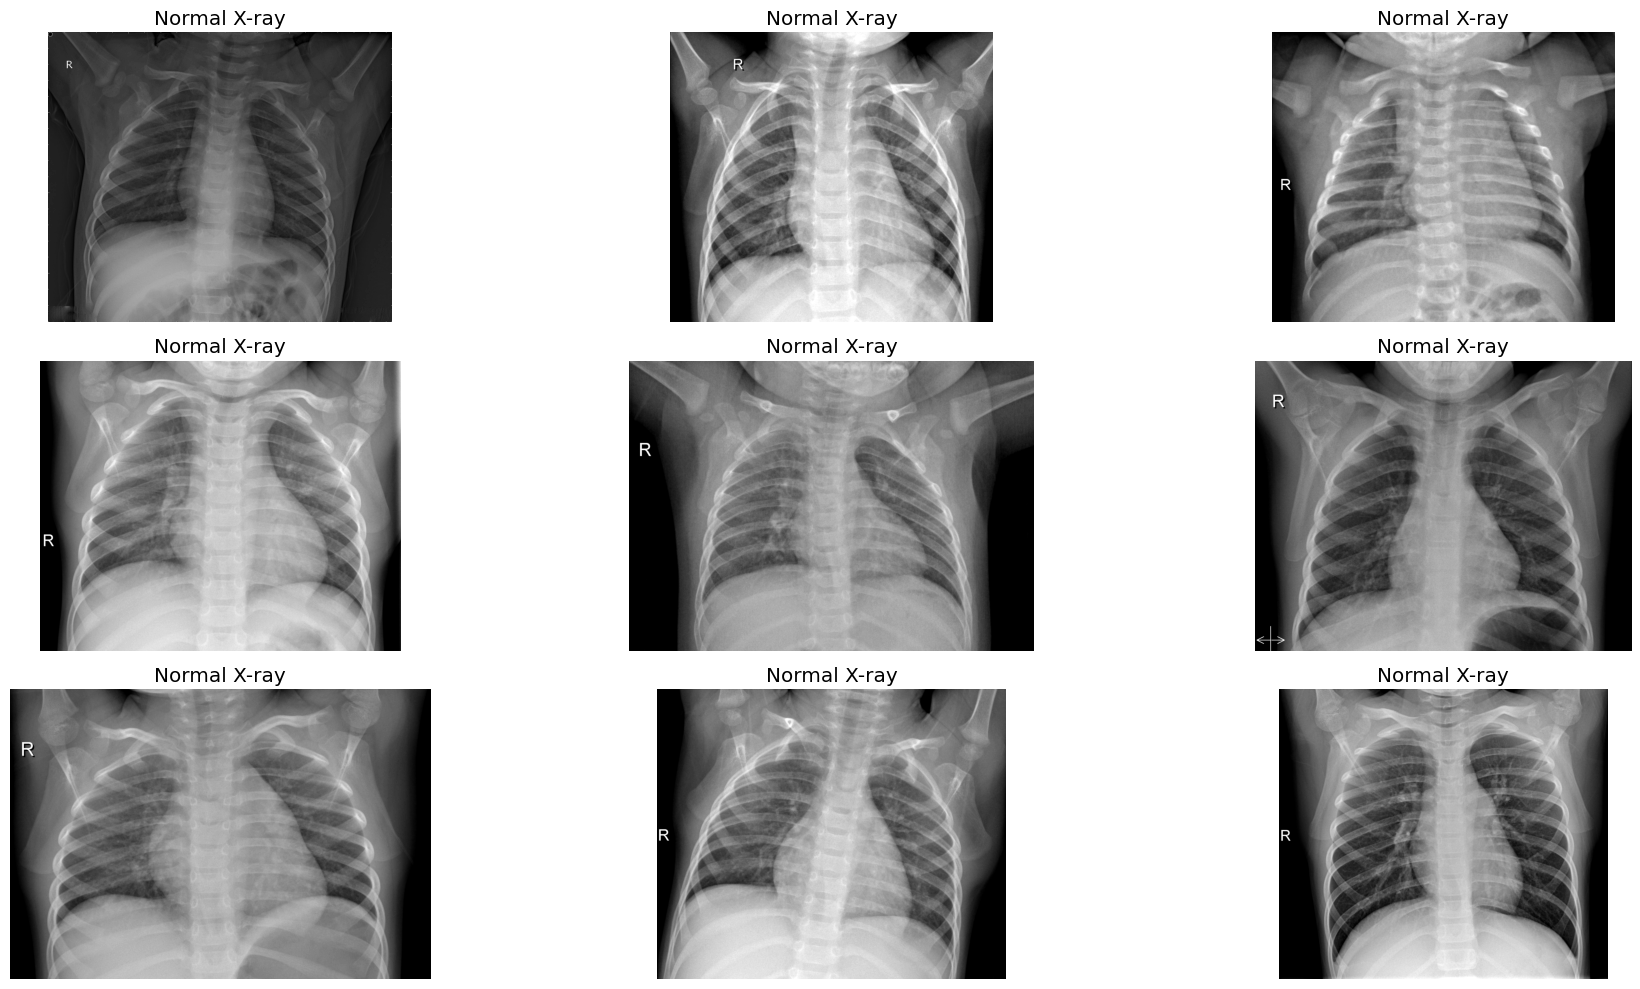

In [6]:
plt.figure(figsize=(20,10))

for i in range(9):
    plt.subplot(3,3, i+1)
    img = plt.imread(os.path.join(normal_dir, normal[i]))
    plt.imshow(img, cmap='gray')
    plt.axis("off")
    plt.title("Normal X-ray")
plt.tight_layout()

In [7]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D,Dropout
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [8]:
train_datagen = ImageDataGenerator(rescale = 1. / 255, 
    rotation_range=40,
    width_shift_range=0.4,
    height_shift_range=0.4,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode="nearest")
valid_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

In [9]:
train_generator = train_datagen.flow_from_directory("/kaggle/input/chest-xray-pneumonia/chest_xray/train",
                                 batch_size = 32,
                                 target_size=(224,224),
                                 class_mode = 'categorical',
                                 shuffle=True,
                                 seed = 42,
                                 color_mode = 'rgb')
valid_generator = valid_datagen.flow_from_directory("/kaggle/input/chest-xray-pneumonia/chest_xray/val",
                                 batch_size = 32,
                                 target_size=(224,224),
                                 class_mode = 'categorical',
                                 shuffle=True,
                                 seed = 42,
                                 color_mode = 'rgb')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [10]:
class_labels = train_generator.class_indices
class_name = {value:key for (key, value) in class_labels.items()}

In [11]:
class_name

{0: 'NORMAL', 1: 'PNEUMONIA'}

In [12]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
base_model = DenseNet121(input_shape=(224,224,3),
                        include_top=False,
                        weights='imagenet')
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
flat = Flatten()(x)

class_1 = Dense(4608, activation='relu')(flat)
dropout = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation='relu')(dropout)
output = Dense(2, activation='softmax')(class_2)

# Create the final model
model_01 = Model(base_model.inputs, output)
model_01.summary()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,408 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_1          │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 56, 56, 64)     │              0 │ zero_padding2d_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 56, 56, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 56, 56, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block2_0_bn    

 Total params: 243,564,994 (929.13 MB)

 Trainable params: 236,527,490 (902.28 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [13]:
filepath = "model.keras"
es = EarlyStopping(monitor="val_loss", verbose=1, mode="min", patience=4)
cp=ModelCheckpoint(filepath, monitor="val_loss", save_best_only=True, save_weights_only=False,mode="auto", save_freq="epoch")
lrr = ReduceLROnPlateau(monitor="val_accuracy", patience=3, verbose=1, factor=0.5, min_lr=0.0001)

sgd = SGD(learning_rate=0.0001, decay = 1e-6, momentum=0.1, nesterov = True)

model_01.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [14]:
history_01 = model_01.fit(train_generator, 
            steps_per_epoch=70,
            epochs=2, 
            callbacks=[es, cp, lrr],
            validation_data=valid_generator)

Epoch 1/2


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


70/70 ━━━━━━━━━━━━━━━━━━━━ 88s 858ms/step - accuracy: 0.7148 - loss: 0.6217 - val_accuracy: 0.8125 - val_loss: 0.3702 - learning_rate: 1.0000e-04
Epoch 2/2
70/70 ━━━━━━━━━━━━━━━━━━━━ 49s 710ms/step - accuracy: 0.8156 - loss: 0.3906 - val_accuracy: 0.8750 - val_loss: 0.3366 - learning_rate: 1.0000e-04


In [15]:
if not os.path.isdir('model_weights/'):
    os.mkdir("model_weights/")
model_01.save(filepath = "model_weights/xception_model_01.h5", overwrite=True)

In [16]:
test_generator = test_datagen.flow_from_directory("/kaggle/input/chest-xray-pneumonia/chest_xray/test",
                                 batch_size = 32,
                                 target_size=(224,224),
                                 class_mode = 'categorical',
                                 shuffle=True,
                                 seed = 42,
                                 color_mode = 'rgb')

Found 624 images belonging to 2 classes.


In [17]:
model_01.load_weights("/kaggle/working/model_weights/xception_model_01.h5")

vgg_val_eval_01 = model_01.evaluate(valid_generator)
vgg_test_eval_01 = model_01.evaluate(test_generator)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.8750 - loss: 0.3366
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 225ms/step - accuracy: 0.7810 - loss: 0.4351


In [18]:
print(f"Validation Loss: {vgg_val_eval_01[0]}")
print(f"Validation Accuarcy: {vgg_val_eval_01[1]}")
print(f"Test Loss: {vgg_test_eval_01[0]}")
print(f"Test Accuarcy: {vgg_test_eval_01[1]}")

Validation Loss: 0.336605042219162
Validation Accuarcy: 0.875
Test Loss: 0.42266008257865906
Test Accuarcy: 0.7852563858032227


In [19]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
base_model = DenseNet121(include_top=False, input_shape=(224,224,3))
base_model_layer_names = [layer.name for layer in base_model.layers]

x = base_model.output
flat = Flatten()(x)

class_1 = Dense(4608, activation='relu')(flat)
dropout = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation='relu')(dropout)
output = Dense(2, activation='softmax')(class_2)
model_02 = Model(base_model.inputs, output)
model_02.load_weights("/kaggle/working/model_weights/xception_model_01.h5")  # Note: weights might need adjustment

# Fine-tune last layers 
set_trainable = False
for layer in base_model.layers:
    if layer.name in ['conv5_block16_1_conv', 'conv5_block16_2_conv']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [20]:
sgd = SGD(learning_rate=0.0001, decay = 1e-6, momentum=0.1, nesterov = True)

model_02.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=['accuracy'])

In [21]:
history_02 = model_02.fit(train_generator, 
            steps_per_epoch=50,
            epochs=1, 
            callbacks=[es, cp, lrr],
            validation_data=valid_generator)

50/50 ━━━━━━━━━━━━━━━━━━━━ 69s 916ms/step - accuracy: 0.7932 - loss: 0.4626 - val_accuracy: 0.9375 - val_loss: 0.2495 - learning_rate: 1.0000e-04


In [22]:
if not os.path.isdir('/kaggle/working/model_weights/'):
    os.mkdir("/kaggle/working/model_weights/")
model_02.save(filepath = "model_weights/DenseNet121.h5", overwrite=True)

In [23]:
model_02.load_weights("/kaggle/working/model_weights/DenseNet121.h5")

vgg_val_eval_02 = model_02.evaluate(valid_generator)
vgg_test_eval_02 = model_02.evaluate(test_generator)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.9375 - loss: 0.2495
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 236ms/step - accuracy: 0.8687 - loss: 0.3481


In [25]:
model_02.load_weights("/kaggle/working/model_weights/DenseNet121.h5")
val_loss_02, val_acc_02 = model_02.evaluate(valid_generator)
test_loss_02, test_acc_02 = model_02.evaluate(test_generator)
print(f"Model 2 - Val Loss: {val_loss_02}, Val Acc: {val_acc_02}, Test Loss: {test_loss_02}, Test Acc: {test_acc_02}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.9375 - loss: 0.2495
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 240ms/step - accuracy: 0.8658 - loss: 0.3732
Model 2 - Val Loss: 0.249472513794899, Val Acc: 0.9375, Test Loss: 0.36188986897468567, Test Acc: 0.8653846383094788
